In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import StandardScaler
import numpy as np

In [81]:
train_image_path = 'dataset/train_images.idx3-ubyte'
train_label_path = 'dataset/train_labels.idx1-ubyte'
test_image_path  = 'dataset/test_image.idx3-ubyte'
test_label_path  = 'dataset/test_label.idx1-ubyte'

In [82]:
def image_process(path_file):
    with open(path_file, 'rb') as file:
        data = np.fromfile(file, np.uint8, offset=16)
        data = data / 255
        return data.reshape(-1, 28, 28)


In [83]:
def label_process(path_file):
    with open(path_file, 'rb') as file:
        data = np.fromfile(file, np.uint8, offset=8)
        return data


In [84]:
X_train = image_process(train_image_path)
X_test  = image_process(test_image_path)
y_train = label_process(train_label_path)
y_test  = label_process(test_label_path)

In [85]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [86]:
X_train[0].shape

(28, 28)

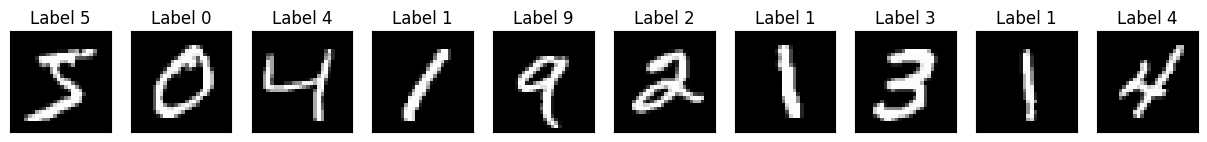

In [87]:
fig = plt.figure(figsize=(20,10))
for i in range(10):
    ax = plt.subplot(1,13,i+1)
    ax.imshow(X_train[i] , cmap='gray')
    plt.title('Label ' + str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
    plt.show

In [88]:
# validation set 
random_indices = np.random.permutation(X_train.shape[0])
length_i = int(X_train.shape[0]*0.2)  # 20% pour la validation
val_indices = random_indices[: length_i]
train_indices = random_indices[length_i :]
X_val = X_train[val_indices]
X_train = X_train[train_indices]
y_val = y_train[val_indices]
y_train = y_train[train_indices]

In [89]:
X_train.shape , y_train.shape , X_val.shape , y_val.shape 

((48000, 28, 28), (48000,), (12000, 28, 28), (12000,))

# Modele 1 : K-nearest neighbors

In [90]:
class KNNClassifier:
    def euclideanDistance(self, x1, x2):
        return np.sqrt(np.sum(np.square(x1 - x2))) 
    
    def manhattanDistance(self, x1, x2):
        return np.sum(np.abs(x1 - x2))
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predect(self, k, X_test, distance='euclidean', weights='uniform'):
        y_pred = []
        
        for x in X_test:
            if distance == 'manhattan':
                distances = [self.manhattanDistance(x, x_train) for x_train in self.X_train]
            else:
                distances = [self.euclideanDistance(x, x_train) for x_train in self.X_train]
                     
            k_indices = np.argsort(distances)[:k]
            k_labels = self.y_train[k_indices]
            
            if weights == 'distance':
                y = k_labels[np.argmax(np.bincount(k_labels) * (1 / distances[k_indices]))]
                y_pred.append(y)
            else:
                y = np.argmax(np.bincount(k_labels))
                y_pred.append(y)
        
        return np.array(y_pred)
            

In [91]:
# PARAMETRES 
k = 4
distance_type = 'manhattan'
weight_type = 'uniform'

# prend en petit partie du data

xpetit_train = X_train[ : 500]
ypetit_train = y_train[ : 500]

xpetit_test = X_test[ : 10]
ypetit_test = y_test[ : 10]

xpetit_train = np.reshape(xpetit_train, (xpetit_train.shape[0], -1))
train = np.reshape(ypetit_train, (ypetit_train.shape[0], -1))
xpetit_test = np.reshape(xpetit_test, (xpetit_test.shape[0], -1))
ypetit_test = np.reshape(ypetit_test, (ypetit_test.shape[0], -1))



In [92]:
model = KNNClassifier()

model.fit(xpetit_train , ypetit_train)

y_pred = model.predect( k , xpetit_test, distance=distance_type, weights=weight_type)

accuracy = accuracy_score(ypetit_test, y_pred)
print("Accuracy : {:.2f}%".format(accuracy * 100))

Accuracy : 80.00%


In [93]:
model = KNeighborsClassifier(n_neighbors=k)

model.fit(xpetit_train, ypetit_train)

y_pred = model.predict(xpetit_test)

accuracy = accuracy_score(ypetit_test, y_pred)
print("Accuracy : {:.2f}%".format(accuracy * 100))

Accuracy : 90.00%


# Modele 2 : Logistique regression

In [101]:
class LogistiqueClssifieur:
    
    def __init__(self, alpha, iterations, normalize = True):
        self.alpha = alpha
        self.iterations = iterations    
        self.normalize = normalize    
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X_train, y_train):
        # recuperer nombre du classe 
        self.classes = np.unique(y_train)
        self.nombre_classes = len(self.classes)
        # pour ajouter 1 
        intercept = np.ones((X_train.shape[0], 1))
        self.X_train = X_train.reshape(X_train.shape[0] , -1)
        # faire normalisation
        if self.normalize :
            scaler = StandardScaler()
            scaler.fit( self.X_train)
            self.X_train = np.column_stack((intercept, scaler.transform(self.X_train)))
        else : self.X_train = np.column_stack((intercept, X_train))
        
        self.y_train = y_train.reshape(y_train.shape[0] , 1)  
        #initilaiser les thetas      
        self.theta = np.zeros((self.nombre_classes , self.X_train.shape[1]))
        # mise a jour les theta 
        self.predictOneVsALL()
    
    def derivative(self, theta):       
        m = len(self.X_train)
        h_theta = self.sigmoid(self.X_train @ theta.T)
        return (self.X_train.T @ (h_theta - self.y_train)).T / m 
    
    
    
    def computeCostLogistique(self, theta , y):
        m = len(self.X_train)
        h_theta = self.sigmoid(self.X_train @ theta.T )        
        h_theta[h_theta == 0.] += np.finfo(float).eps
        h_theta[h_theta == 1.] -= np.finfo(float).eps  
        return - np.sum( y.T @ np.log(h_theta) + (1 - y).T @ np.log(1 - h_theta))  / m

    def gradientDescent(self , y):
        theta_optimum = np.zeros((1 , self.X_train.shape[1]))
        theta = np.array(theta_optimum)
        cost_optimum = self.computeCostLogistique(theta,y)
        for i in range(self.iterations):
            delta_theta = self.derivative(theta)            
            theta = theta - self.alpha * delta_theta         
            cost = self.computeCostLogistique(theta, y)
            print(cost)
            print(cost_optimum)
            if cost_optimum > cost:
                theta_optimum = np.array(theta)
                cost_optimum = cost
        print(cost_optimum)
        return theta_optimum
    
    def predictOneVsALL(self ):                
        for i in range(self.nombre_classes):            
            theta = self.gradientDescent( ( self.y_train == self.classes[i] ).astype(int))
            self.theta[i, :] = theta
            
         
    
    def predict(self, X_test):
        intercept = np.ones((X_test.shape[0], 1))
        X_test = X_test.reshape(X_test.shape[0] , -1)
        if self.normalize :
            scaler = StandardScaler()
            scaler.fit(X_test)
            return np.column_stack((intercept, scaler.transform(X_test))) @ self.theta.T
        return np.column_stack((intercept, X_test)) @ self.theta


In [102]:
model = LogistiqueClssifieur(0.01 , 1000)
model.fit(X_train[ : 500] , y_train[ : 500])

0.8300542817748938
0.6931471805599451
1.0123936288636872
0.6931471805599451
1.2182395091518177
0.6931471805599451
1.4367451198374697
0.6931471805599451
1.662722732700207
0.6931471805599451
1.8934920327820182
0.6931471805599451
2.127545397036268
0.6931471805599451
2.36396901568091
0.6931471805599451
2.602172932453147
0.6931471805599451
2.841755762876731
0.6931471805599451
3.082432406008199
0.6931471805599451
3.3239931487762715
0.6931471805599451
3.566279315027418
0.6931471805599451
3.8091680814670763
0.6931471805599451
4.052562609070342
0.6931471805599451
4.296385388265259
0.6931471805599451
4.540573603377286
0.6931471805599451
4.785075811472299
0.6931471805599451
5.029849504447708
0.6931471805599451
5.274859284328928
0.6931471805599451
5.520075466209891
0.6931471805599451
5.765473004422741
0.6931471805599451
6.011030659671257
0.6931471805599451
6.256730283318075
0.6931471805599451
6.502556421977502
0.6931471805599451
6.748495422172376
0.6931471805599451
6.994535592550006
0.693147180559

C:\Users\client\AppData\Local\Temp\ipykernel_13772\4080239965.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


53.92732365314508
0.6931471805599451
53.988882028644205
0.6931471805599451
54.04987593736465
0.6931471805599451
54.11167040697103
0.6931471805599451
54.172679155240736
0.6931471805599451
54.233663872364254
0.6931471805599451
54.29545394120532
0.6931471805599451
54.35644676435382
0.6931471805599451
54.41745139973026
0.6931471805599451
54.47844021744621
0.6931471805599451
54.539429454094616
0.6931471805599451
54.601807384839425
0.6931471805599451
54.66280090394932
0.6931471805599451
54.72381994005497
0.6931471805599451
54.78480502761193
0.6931471805599451
54.84716118316838
0.6931471805599451
54.908159033530886
0.6931471805599451
54.96914982196807
0.6931471805599451
55.03015039628279
0.6931471805599451
55.09112071501978
0.6931471805599451
55.15214210237747
0.6931471805599451
55.21310607594599
0.6931471805599451
55.274112605362
0.6931471805599451
55.33508934951434
0.6931471805599451
55.3960857911969
0.6931471805599451
55.457081212587305
0.6931471805599451
55.51806777416816
0.69314718055994

In [108]:
ypred = model.predict(X_test)
print(ypred[10])

[ 0.          0.          0.          0.          0.          0.
  0.         -1.11847208  0.         -1.11847208]


In [104]:
print(model.theta)

[[0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]
 ...
 [0.04178 0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]
 [0.04178 0.      0.      ... 0.      0.      0.     ]]


In [105]:
# ypred = model.predict(X_test)
# y_test = y_test.reshape(y_test.shape[0] , 1)
# accuracy = accuracy_score(y_test, ypred)
# print("Accuracy : {:.2f}%".format(accuracy * 100))